# Hilbert distance-based split into train and test

This notebook illustrates the core of the approach to split chips into train and test used in the CEUS paper. There it was a bit more complicated than that but the principle is illustrated here.

In [16]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import box

Get only a subset of the country for illustration - NW.

In [3]:
start_x, start_y, end_x, end_y = (321566, 365379, 468106, 437198)

Load the data and clip them to the box defined above. The data from https://figshare.com/ndownloader/files/38736501

In [4]:
signatures  = gpd.read_file("/Users/martin/Downloads/spatial_signatures_GB_simplified.gpkg", bbox=(start_x, start_y, end_x, end_y)).clip(box(start_x, start_y, end_x, end_y))

Get coordinates of chip centroids.

In [5]:
x_coords = np.arange(start_x, end_x, 250)
y_coords = np.arange(start_y, end_y, 250)
xv, yv = np.meshgrid(x_coords, y_coords)
combinations = np.vstack([xv.ravel(), yv.ravel()])

Get chip geoemtry.

In [6]:
grid_cells = gpd.GeoSeries.from_xy(x=combinations[0], y=combinations[1], crs=signatures.crs).buffer(125, cap_style=3)

Filter only those fully within signatures.

In [7]:
sig_idx, grid_idx = grid_cells.sindex.query(signatures.geometry, predicate="contains")
valid_grid_cells = grid_cells.iloc[grid_idx].to_frame('geometry')
valid_grid_cells["sig_id"] = sig_idx

Get unique signature IDs to pull from.

In [8]:
unique = valid_grid_cells.sig_id.unique()
unique.shape[0]

745

Illustrate the split using Hilbert distance. Chip groups with less than 20 chips are not split and should be allocated together either to train or test. The distance itself could be retrieved via `GeoSeries.hilbert_distance()` if needed.

Text(0.5, 1.0, 'hilbert distance')

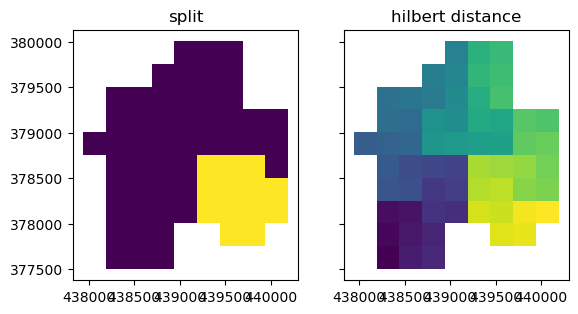

In [27]:
g = valid_grid_cells[valid_grid_cells.sig_id == unique[79]]
if g.shape[0] > 20:
    split = np.empty(g.shape[0], dtype=int)
    floor = int(np.floor(g.shape[0] * 0.8))
    split[:floor] = 0
    split[floor:] = 1
else:
    split = np.ones(g.shape[0])

f, ax = plt.subplots(1, 2, sharey=True)
g.sort_values("geometry").plot(split, ax=ax[0])
g.sort_values("geometry").plot(cmap="viridis", ax=ax[1])
ax[0].set_title("split")
ax[1].set_title("hilbert distance")